Import das bibliotecas necessárias para execução e criação dos modelos

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:
#Load dataset
def load_dataset(path=r'dataset_final_semanal.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.copy()
  df_aux["Date"] = pd.to_datetime(df_aux["Date"])
  df_aux = df_aux.set_index('Date')
  df_aux = df_aux.drop(columns=["Unnamed: 0"])

  return df_aux

In [6]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [7]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  colunas = [x for x in df.columns if x != 'obitos']
  for col in colunas:
    df[[col]] = scaler.fit_transform(df[[col]])
  df[['obitos']] = scaler.fit_transform(df[['obitos']])
  return scaler

In [8]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [9]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [10]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
      # y.append(data[input_index:label_index, 0:n_variate])

  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [11]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [12]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  # model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
  return model

In [13]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size, learning_rate):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [14]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

In [15]:
df

,obitos,confirmados_novos,recuperados,Temperature,Visibility,total_testes,testes_pcr,testes_antigenio,new_cases_per_million_Austria,new_deaths_per_million_Austria,new_cases_per_million_Belgium,new_deaths_per_million_Belgium,icu_patients_per_million_Belgium,hosp_patients_per_million_Belgium,new_deaths_per_million_Bulgaria,new_cases_per_million_Canada,new_deaths_per_million_Canada,icu_patients_per_million_Canada,new_cases_per_million_Cyprus,new_deaths_per_million_Czechia,hosp_patients_per_million_Czechia,new_cases_per_million_Denmark,new_tests_per_thousand_Estonia,icu_patients_per_million_France,new_cases_per_million_Georgia,new_cases_per_million_Germany,new_deaths_per_million_Germany,icu_patients_per_million_Germany,new_deaths_per_million_Hungary,hosp_patients_per_million_Hungary,positive_rate_India,new_cases_per_million_Ireland,new_deaths_per_million_Ireland,icu_patients_per_million_Ireland,hosp_patients_per_million_Ireland,new_tests_per_thousand_Ireland,positive_rate_Ireland,new_tests_per_thousand_Italy,new_cases_per_million_Japan,new_deaths_per_million_Japan,...,icu_patients_per_million_Luxembourg,new_deaths_per_million_Malta,new_tests_per_thousand_Malta,positive_rate_Malta,new_cases_per_million_Monaco,new_cases_per_million_Montenegro,positive_rate_Mozambique,new_deaths_per_million_Poland,positive_rate_Romania,new_cases_per_million_Russia,new_deaths_per_million_Russia,new_deaths_per_million_Serbia,positive_rate_Serbia,new_cases_per_million_Slovakia,new_tests_per_thousand_Slovakia,new_cases_per_million_Slovenia,new_deaths_per_million_Slovenia,icu_patients_per_million_Slovenia,new_tests_per_thousand_Slovenia,new_deaths_per_million_Switzerland,new_cases_per_million_Turkey,positive_rate_Ukraine,new_deaths_per_million_United Arab Emirates,tests_per_case_United Arab Emirates,new_cases_per_million_United Kingdom,new_deaths_per_million_United Kingdom,icu_patients_per_million_United Kingdom,hosp_patients_per_million_United Kingdom,positive_rate_United Kingdom,new_cases_per_million_United States,new_deaths_per_million_United States,COVID-19 Deaths,Pneumonia Deaths,Influenza Deaths,flights,commercial_flights,People Screened at Airports,US International Commercial Flights,Nr People not staying home,Nr of trips
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,-1.000000,-1.000000,-1.000000,-0.274766,0.410117,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.912926,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.995806,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.996975,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.907514,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.891741,-1.000000,-1.000000,-1.000000,0.872598,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999375,1.000000,0.974134,1.000000,1.000000,1.000000,0.977380,0.613777
2020-03-08,-1.000000,-0.999305,-1.000000,-0.235083,0.657588,-0.998023,-0.997653,-1.000000,-0.996929,-1.000000,-0.996716,-0.912926,-1.000000,-1.000000,-1.000000,-0.999125,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.997652,-0.992788,-0.995772,-0.999535,-0.990282,-1.000000,-1.000000,-1.000000,-0.999476,-1.000000,-0.999256,-0.995806,-1.000000,-0.994868,-1.000000,-1.000000,-0.985604,-0.992907,-1.000000,...,-1.000000,-1.000000,-0.980634,-1.000000,-0.919075,-1.000000,-1.000000,-1.000000,-1.000000,-0.999849,-1.000000,-1.000000,-1.000000,-0.999711,-0.999550,-0.997746,-1.000000,-1.000000,-0.960587,-0.886307,-1.000000,-1.000000,-1.000000,1.000000,-0.998428,-0.999532,-1.000000,-1.000000,-1.000000,-0.999453,-0.998414,-0.998359,-1.000000,0.971564,1.000000,0.961335,0.723045,0.980974,1.000000,0.662269
2020-03-15,-1.000000,-0.995023,-0.999950,-0.094177,0.642023,-0

In [16]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    # se for necessário prever mais do que 1 semana
    # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    # print('list_yhat:')
    # print(list_yhat)
    # #preparar novo input para fazer previsão para a semana seguinte
    # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
    # print('forecasts:')
    # print(forecasts)
  return forecasts



In [17]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(20,8))
  plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Óbitos em Portugal')
  plt.ylabel('Número de Óbitos')
  plt.xlabel('Semanas')
  plt.legend()
  plt.show()

# Tunning

In [18]:
tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
# record da history de cada modelo
record = {}

Epoch 1/25
15/15 [==============================] - 4s 58ms/step - loss: 0.8596 - mae: 0.8583 - rmse: 0.8596 - val_loss: 0.8309 - val_mae: 0.8241 - val_rmse: 0.8309
Epoch 2/25
15/15 [==============================] - 0s 4ms/step - loss: 0.5712 - mae: 0.5343 - rmse: 0.5712 - val_loss: 0.3426 - val_mae: 0.2637 - val_rmse: 0.3426
Epoch 3/25
15/15 [==============================] - 0s 5ms/step - loss: 0.2346 - mae: 0.1813 - rmse: 0.2346 - val_loss: 0.1313 - val_mae: 0.1037 - val_rmse: 0.1313
Epoch 4/25
15/15 [==============================] - 0s 4ms/step - loss: 0.0827 - mae: 0.0696 - rmse: 0.0827 - val_loss: 0.0293 - val_mae: 0.0234 - val_rmse: 0.0293
Epoch 5/25
15/15 [==============================] - 0s 4ms/step - loss: 0.0526 - mae: 0.0483 - rmse: 0.0526 - val_loss: 0.0330 - val_mae: 0.0306 - val_rmse: 0.0330
Epoch 6/25
15/15 [==============================] - 0s 4ms/step - loss: 0.0438 - mae: 0.0416 - rmse: 0.0438 - val_loss: 0.0241 - val_mae: 0.0225 - val_rmse: 0.0241
Epoch 7/25
15/1

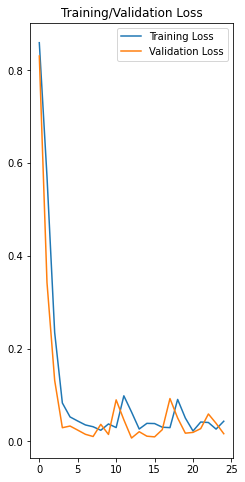

Epoch 1/25
27/27 [==============================] - 0s 5ms/step - loss: 0.0511 - mae: 0.0493 - rmse: 0.0511 - val_loss: 0.0419 - val_mae: 0.0417 - val_rmse: 0.0419
Epoch 2/25
27/27 [==============================] - 0s 4ms/step - loss: 0.0402 - mae: 0.0392 - rmse: 0.0402 - val_loss: 0.0109 - val_mae: 0.0089 - val_rmse: 0.0109
Epoch 3/25
27/27 [==============================] - 0s 4ms/step - loss: 0.0304 - mae: 0.0295 - rmse: 0.0304 - val_loss: 0.0208 - val_mae: 0.0206 - val_rmse: 0.0208
Epoch 4/25
27/27 [==============================] - 0s 4ms/step - loss: 0.0367 - mae: 0.0357 - rmse: 0.0367 - val_loss: 0.0124 - val_mae: 0.0116 - val_rmse: 0.0124
Epoch 5/25
27/27 [==============================] - 0s 4ms/step - loss: 0.0286 - mae: 0.0277 - rmse: 0.0286 - val_loss: 0.0140 - val_mae: 0.0131 - val_rmse: 0.0140
Epoch 6/25
27/27 [==============================] - 0s 4ms/step - loss: 0.0227 - mae: 0.0217 - rmse: 0.0227 - val_loss: 0.0086 - val_mae: 0.0080 - val_rmse: 0.0086
Epoch 7/25
27/27

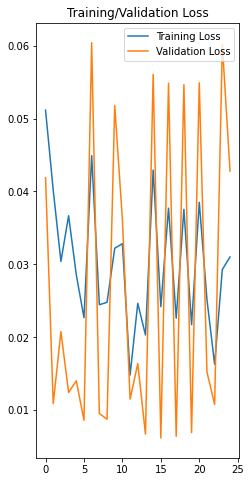

Epoch 1/25
40/40 [==============================] - 0s 5ms/step - loss: 0.0370 - mae: 0.0359 - rmse: 0.0370 - val_loss: 0.2626 - val_mae: 0.2615 - val_rmse: 0.2626
Epoch 2/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0319 - mae: 0.0305 - rmse: 0.0319 - val_loss: 0.0706 - val_mae: 0.0675 - val_rmse: 0.0706
Epoch 3/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0771 - mae: 0.0756 - rmse: 0.0771 - val_loss: 0.1299 - val_mae: 0.1283 - val_rmse: 0.1299
Epoch 4/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0335 - mae: 0.0323 - rmse: 0.0335 - val_loss: 0.0851 - val_mae: 0.0827 - val_rmse: 0.0851
Epoch 5/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0378 - mae: 0.0362 - rmse: 0.0378 - val_loss: 0.0638 - val_mae: 0.0618 - val_rmse: 0.0638
Epoch 6/25
40/40 [==============================] - 0s 4ms/step - loss: 0.0319 - mae: 0.0303 - rmse: 0.0319 - val_loss: 0.0539 - val_mae: 0.0517 - val_rmse: 0.0539
Epoch 7/25
40/40

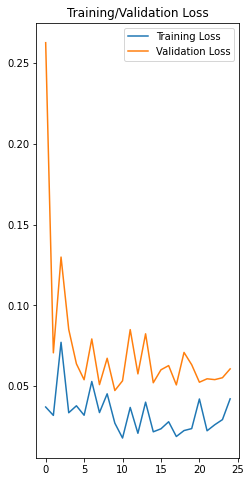

[array([[182.12389, 182.85614, 187.35597, 184.73132, 185.7723 , 183.5352 ,
        194.02847, 182.25275, 181.49829, 185.08688, 181.71834, 171.70752,
        182.51743, 194.73926, 175.85188, 197.10558, 187.4219 , 198.88255,
        165.99615, 197.98764, 180.99207, 188.70795, 183.93594, 181.0823 ,
        182.9876 , 177.97357, 179.8875 , 192.00578, 185.2439 , 193.87238,
        184.57185, 186.3616 , 179.12662, 194.44913, 181.61731, 192.03685,
        170.10777, 183.08844, 183.51906, 176.4547 , 187.71329, 196.08163,
        187.91125, 187.47824, 178.36879, 192.67732, 187.74286, 181.26006,
        187.99681, 201.01245, 195.84137, 180.35345, 199.29349, 195.86873,
        185.50174, 184.36795, 175.3047 , 191.44197, 178.09013, 186.41098,
        195.01186, 193.20657, 173.58054, 173.41112, 195.9656 , 177.55237,
        179.01959, 190.30806, 184.50113, 182.77942, 176.89438, 187.42688,
        197.6343 , 185.64296, 173.24266, 180.31674, 177.64967, 191.41246,
        193.49658, 184.40286, 202.915

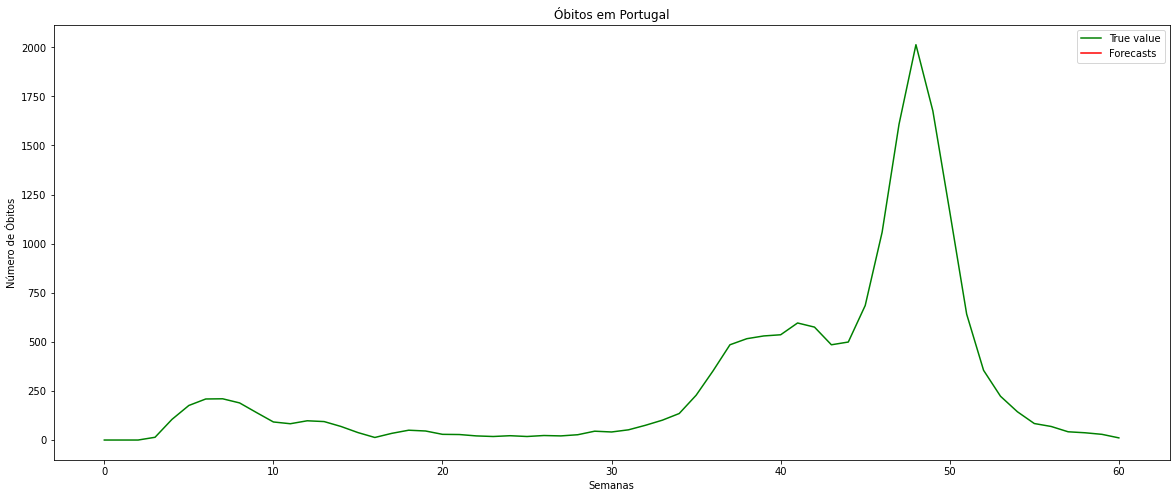

Epoch 1/50
8/8 [==============================] - 4s 115ms/step - loss: 0.8991 - mae: 0.8986 - rmse: 0.9028 - val_loss: 0.9621 - val_mae: 0.9617 - val_rmse: 0.9621
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.8955 - mae: 0.8950 - rmse: 0.8992 - val_loss: 0.9581 - val_mae: 0.9577 - val_rmse: 0.9581
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.8918 - mae: 0.8912 - rmse: 0.8955 - val_loss: 0.9539 - val_mae: 0.9534 - val_rmse: 0.9539
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.8877 - mae: 0.8871 - rmse: 0.8913 - val_loss: 0.9490 - val_mae: 0.9484 - val_rmse: 0.9490
Epoch 5/50
8/8 [==============================] - 0s 7ms/step - loss: 0.8830 - mae: 0.8822 - rmse: 0.8866 - val_loss: 0.9434 - val_mae: 0.9425 - val_rmse: 0.9434
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.8775 - mae: 0.8765 - rmse: 0.8810 - val_loss: 0.9366 - val_mae: 0.9354 - val_rmse: 0.9366
Epoch 7/50
8/8 [==========

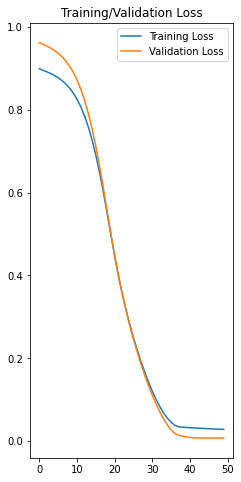

Epoch 1/50
14/14 [==============================] - 0s 9ms/step - loss: 0.0278 - mae: 0.0260 - rmse: 0.0280 - val_loss: 0.0384 - val_mae: 0.0364 - val_rmse: 0.0400
Epoch 2/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0306 - mae: 0.0281 - rmse: 0.0307 - val_loss: 0.0392 - val_mae: 0.0369 - val_rmse: 0.0408
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0271 - mae: 0.0246 - rmse: 0.0272 - val_loss: 0.0374 - val_mae: 0.0353 - val_rmse: 0.0390
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0268 - mae: 0.0242 - rmse: 0.0268 - val_loss: 0.0344 - val_mae: 0.0320 - val_rmse: 0.0360
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.0265 - mae: 0.0238 - rmse: 0.0264 - val_loss: 0.0337 - val_mae: 0.0312 - val_rmse: 0.0352
Epoch 6/50
14/14 [==============================] - 0s 6ms/step - loss: 0.0261 - mae: 0.0234 - rmse: 0.0260 - val_loss: 0.0324 - val_mae: 0.0299 - val_rmse: 0.0339
Epoch 7/50
14/14

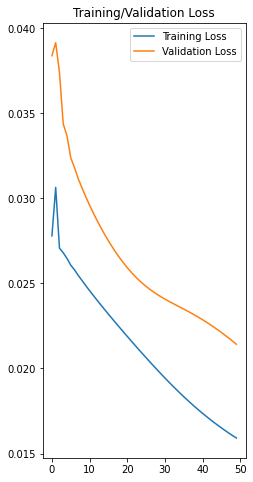

Epoch 1/50
20/20 [==============================] - 2s 44ms/step - loss: 0.0682 - mae: 0.0655 - rmse: 0.0682 - val_loss: 0.4253 - val_mae: 0.4201 - val_rmse: 0.4253
Epoch 2/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0683 - mae: 0.0657 - rmse: 0.0683 - val_loss: 0.4153 - val_mae: 0.4102 - val_rmse: 0.4153
Epoch 3/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0592 - mae: 0.0566 - rmse: 0.0592 - val_loss: 0.4050 - val_mae: 0.4001 - val_rmse: 0.4050
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0563 - mae: 0.0536 - rmse: 0.0563 - val_loss: 0.3951 - val_mae: 0.3903 - val_rmse: 0.3951
Epoch 5/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0515 - mae: 0.0492 - rmse: 0.0515 - val_loss: 0.3854 - val_mae: 0.3807 - val_rmse: 0.3854
Epoch 6/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0486 - mae: 0.0464 - rmse: 0.0486 - val_loss: 0.3763 - val_mae: 0.3716 - val_rmse: 0.3763
Epoch 7/50
20/2

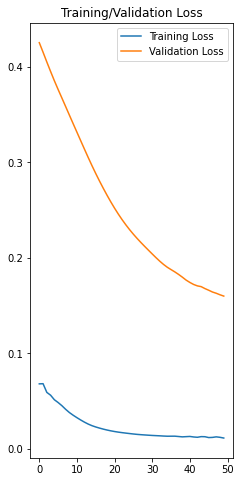

[array([[280.42245, 274.35666, 284.793  , 279.14618, 269.15192, 293.21378,
        311.85403, 298.803  , 295.8182 , 294.48862, 307.3967 , 283.83072,
        281.51468, 291.53708, 285.61502, 293.72894, 295.43692, 282.2344 ,
        294.96683, 293.8008 , 302.60675, 310.7137 , 290.98077, 287.55438,
        286.56342, 312.5458 , 306.70767, 283.9845 , 281.95898, 279.408  ,
        270.72217, 309.4234 , 291.52777, 284.564  , 321.4391 , 282.92426,
        286.43546, 292.66583, 286.19867, 289.07846, 283.48505, 263.41705,
        294.55988, 305.45258, 307.25674, 292.65015, 299.0017 , 288.77432,
        296.29672, 308.66293, 275.08615, 313.1736 , 284.2921 , 270.98816,
        298.62262, 307.3075 , 289.32928, 272.427  , 283.18   , 288.88608,
        293.63385, 307.05035, 274.88916, 285.32986, 289.40094, 293.16165,
        309.8581 , 294.21637, 271.95834, 296.4481 , 311.30237, 313.25198,
        288.87323, 298.3992 , 276.9586 , 295.92758, 301.0571 , 300.8602 ,
        274.23013, 281.77432, 292.802

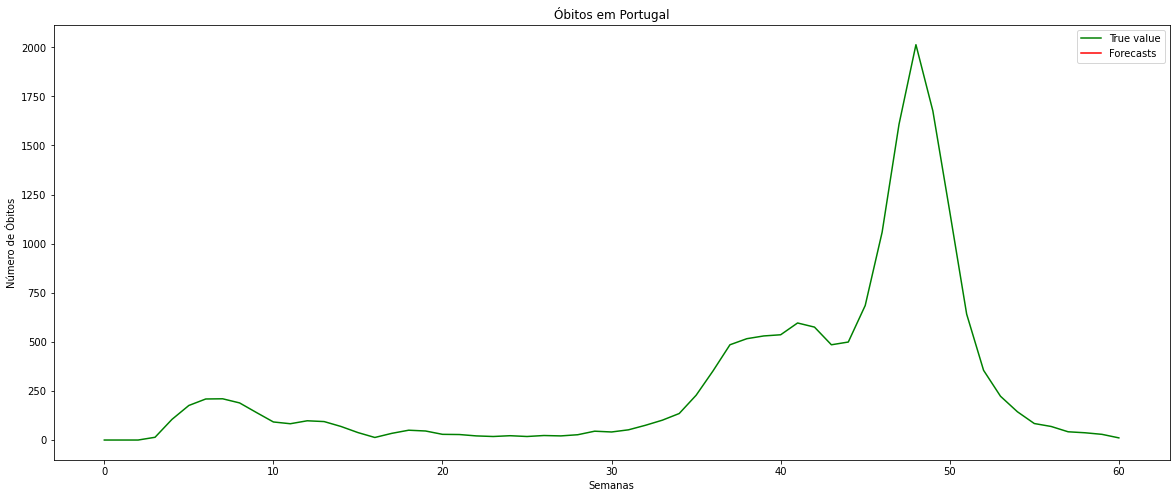

Epoch 1/100
5/5 [==============================] - 3s 195ms/step - loss: 0.9003 - mae: 0.8998 - rmse: 0.9003 - val_loss: 0.9668 - val_mae: 0.9666 - val_rmse: 0.9668
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 0.9001 - mae: 0.8996 - rmse: 0.9001 - val_loss: 0.9665 - val_mae: 0.9664 - val_rmse: 0.9665
Epoch 3/100
5/5 [==============================] - 0s 9ms/step - loss: 0.8999 - mae: 0.8994 - rmse: 0.8999 - val_loss: 0.9663 - val_mae: 0.9661 - val_rmse: 0.9663
Epoch 4/100
5/5 [==============================] - 0s 8ms/step - loss: 0.8997 - mae: 0.8991 - rmse: 0.8997 - val_loss: 0.9660 - val_mae: 0.9659 - val_rmse: 0.9660
Epoch 5/100
5/5 [==============================] - 0s 10ms/step - loss: 0.8994 - mae: 0.8989 - rmse: 0.8994 - val_loss: 0.9658 - val_mae: 0.9657 - val_rmse: 0.9658
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 0.8992 - mae: 0.8987 - rmse: 0.8992 - val_loss: 0.9655 - val_mae: 0.9654 - val_rmse: 0.9655
Epoch 7/100
5/5 [=

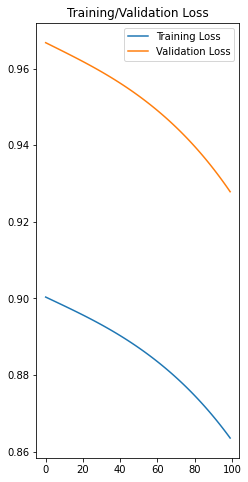

Epoch 1/100
9/9 [==============================] - 1s 100ms/step - loss: 0.8948 - mae: 0.8933 - rmse: 0.8948 - val_loss: 0.9179 - val_mae: 0.9169 - val_rmse: 0.9179
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8935 - mae: 0.8920 - rmse: 0.8935 - val_loss: 0.9166 - val_mae: 0.9155 - val_rmse: 0.9166
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8922 - mae: 0.8906 - rmse: 0.8922 - val_loss: 0.9153 - val_mae: 0.9142 - val_rmse: 0.9153
Epoch 4/100
9/9 [==============================] - 0s 6ms/step - loss: 0.8908 - mae: 0.8891 - rmse: 0.8908 - val_loss: 0.9139 - val_mae: 0.9127 - val_rmse: 0.9139
Epoch 5/100
9/9 [==============================] - 0s 7ms/step - loss: 0.8894 - mae: 0.8876 - rmse: 0.8894 - val_loss: 0.9125 - val_mae: 0.9113 - val_rmse: 0.9125
Epoch 6/100
9/9 [==============================] - 0s 7ms/step - loss: 0.8880 - mae: 0.8861 - rmse: 0.8880 - val_loss: 0.9111 - val_mae: 0.9098 - val_rmse: 0.9111
Epoch 7/100
9/9 [===

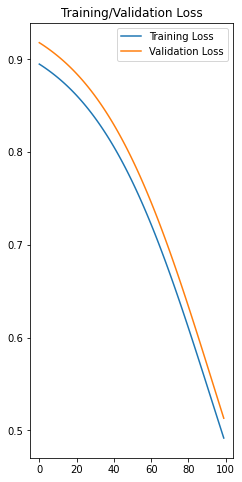

Epoch 1/100
14/14 [==============================] - 2s 9ms/step - loss: 0.4793 - mae: 0.4295 - rmse: 0.4769 - val_loss: 0.4219 - val_mae: 0.4203 - val_rmse: 0.3812
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4711 - mae: 0.4203 - rmse: 0.4690 - val_loss: 0.4213 - val_mae: 0.4197 - val_rmse: 0.3807
Epoch 3/100
14/14 [==============================] - 0s 8ms/step - loss: 0.4634 - mae: 0.4117 - rmse: 0.4616 - val_loss: 0.4206 - val_mae: 0.4190 - val_rmse: 0.3801
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4558 - mae: 0.4035 - rmse: 0.4543 - val_loss: 0.4199 - val_mae: 0.4183 - val_rmse: 0.3794
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4483 - mae: 0.3955 - rmse: 0.4471 - val_loss: 0.4192 - val_mae: 0.4176 - val_rmse: 0.3788
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4409 - mae: 0.3876 - rmse: 0.4400 - val_loss: 0.4185 - val_mae: 0.4169 - val_rmse: 0.3782
Epoch 7/10

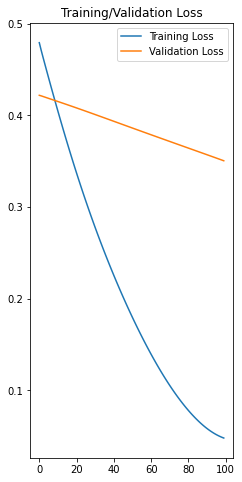

[array([[352.69562, 330.3375 , 291.8753 , 330.14874, 322.5674 , 304.88733,
        336.8637 , 338.84448, 305.84848, 304.08807, 343.72778, 305.29175,
        371.64825, 329.1413 , 309.90802, 346.20526, 375.2659 , 333.1895 ,
        330.90704, 353.40994, 365.45227, 333.09082, 340.0109 , 320.73846,
        328.84625, 343.4935 , 335.48373, 315.26062, 334.06287, 336.0121 ,
        340.00394, 310.1661 , 300.50665, 340.94702, 315.2737 , 347.21402,
        315.64014, 360.36707, 294.78696, 343.85413, 322.17532, 353.18643,
        355.6737 , 346.17624, 314.99557, 339.0091 , 339.65976, 326.5798 ,
        276.8212 , 342.91345, 319.39954, 370.9103 , 323.5849 , 314.18036,
        374.425  , 365.7871 , 289.86185, 354.12122, 305.45276, 295.873  ,
        334.0144 , 295.1145 , 316.60242, 340.75372, 335.6064 , 345.49118,
        326.8427 , 318.67557, 326.30606, 314.62387, 317.54434, 308.46677,
        337.6661 , 369.34302, 303.92374, 341.22183, 326.68848, 340.95477,
        333.72302, 310.05536, 344.352

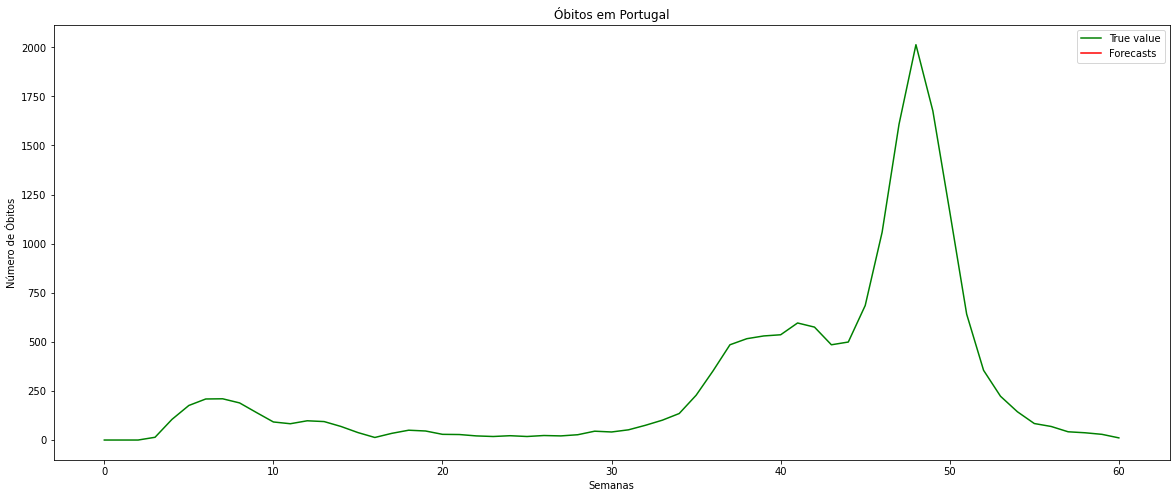

Epoch 1/60
14/14 [==============================] - 4s 61ms/step - loss: 0.8306 - mae: 0.8234 - rmse: 0.8306 - val_loss: 0.7554 - val_mae: 0.7231 - val_rmse: 0.7554
Epoch 2/60
14/14 [==============================] - 0s 7ms/step - loss: 0.4823 - mae: 0.4215 - rmse: 0.4823 - val_loss: 0.2870 - val_mae: 0.2354 - val_rmse: 0.2870
Epoch 3/60
14/14 [==============================] - 0s 5ms/step - loss: 0.1713 - mae: 0.1428 - rmse: 0.1713 - val_loss: 0.0828 - val_mae: 0.0655 - val_rmse: 0.0828
Epoch 4/60
14/14 [==============================] - 0s 6ms/step - loss: 0.1226 - mae: 0.1103 - rmse: 0.1226 - val_loss: 0.0941 - val_mae: 0.0893 - val_rmse: 0.0941
Epoch 5/60
14/14 [==============================] - 0s 7ms/step - loss: 0.0637 - mae: 0.0588 - rmse: 0.0637 - val_loss: 0.0157 - val_mae: 0.0116 - val_rmse: 0.0157
Epoch 6/60
14/14 [==============================] - 0s 7ms/step - loss: 0.0627 - mae: 0.0585 - rmse: 0.0627 - val_loss: 0.0361 - val_mae: 0.0310 - val_rmse: 0.0361
Epoch 7/60
14/1

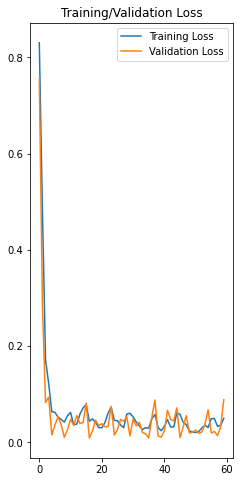

Epoch 1/60
27/27 [==============================] - 0s 6ms/step - loss: 0.0273 - mae: 0.0245 - rmse: 0.0273 - val_loss: 0.0118 - val_mae: 0.0094 - val_rmse: 0.0118
Epoch 2/60
27/27 [==============================] - 0s 5ms/step - loss: 0.0208 - mae: 0.0184 - rmse: 0.0208 - val_loss: 0.0101 - val_mae: 0.0086 - val_rmse: 0.0101
Epoch 3/60
27/27 [==============================] - 0s 5ms/step - loss: 0.0307 - mae: 0.0282 - rmse: 0.0307 - val_loss: 0.0234 - val_mae: 0.0214 - val_rmse: 0.0234
Epoch 4/60
27/27 [==============================] - 0s 4ms/step - loss: 0.0431 - mae: 0.0409 - rmse: 0.0431 - val_loss: 0.0102 - val_mae: 0.0081 - val_rmse: 0.0102
Epoch 5/60
27/27 [==============================] - 0s 5ms/step - loss: 0.0289 - mae: 0.0274 - rmse: 0.0289 - val_loss: 0.0135 - val_mae: 0.0124 - val_rmse: 0.0135
Epoch 6/60
27/27 [==============================] - 0s 5ms/step - loss: 0.0267 - mae: 0.0251 - rmse: 0.0267 - val_loss: 0.0086 - val_mae: 0.0075 - val_rmse: 0.0086
Epoch 7/60
27/27

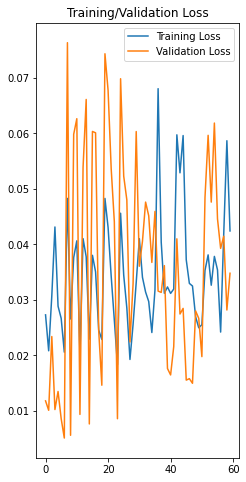

Epoch 1/60
39/39 [==============================] - 0s 5ms/step - loss: 0.0628 - mae: 0.0604 - rmse: 0.0628 - val_loss: 0.3284 - val_mae: 0.3265 - val_rmse: 0.3284
Epoch 2/60
39/39 [==============================] - 0s 5ms/step - loss: 0.0672 - mae: 0.0651 - rmse: 0.0672 - val_loss: 0.1424 - val_mae: 0.1380 - val_rmse: 0.1424
Epoch 3/60
39/39 [==============================] - 0s 5ms/step - loss: 0.0640 - mae: 0.0617 - rmse: 0.0640 - val_loss: 0.0758 - val_mae: 0.0720 - val_rmse: 0.0758
Epoch 4/60
39/39 [==============================] - 0s 5ms/step - loss: 0.0443 - mae: 0.0425 - rmse: 0.0443 - val_loss: 0.0895 - val_mae: 0.0867 - val_rmse: 0.0895
Epoch 5/60
39/39 [==============================] - 0s 5ms/step - loss: 0.0731 - mae: 0.0711 - rmse: 0.0731 - val_loss: 0.0727 - val_mae: 0.0702 - val_rmse: 0.0727
Epoch 6/60
39/39 [==============================] - 0s 4ms/step - loss: 0.0354 - mae: 0.0332 - rmse: 0.0354 - val_loss: 0.0720 - val_mae: 0.0702 - val_rmse: 0.0720
Epoch 7/60
39/39

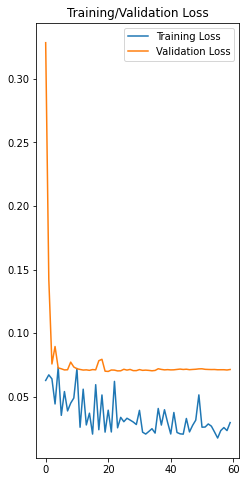

[array([[106.564644,  94.81333 ,  99.85327 ,  87.072914,  94.936676,
        117.927864,  82.05764 , 126.765175, 122.430565,  94.61566 ,
         92.67216 ,  88.64807 ,  90.45113 ,  64.963196, 126.83968 ,
         97.31267 ,  80.99854 ,  72.69474 , 127.46468 ,  89.40253 ,
         79.72287 , 101.37773 , 105.46235 ,  72.198425,  84.003845,
         68.16725 , 115.3617  ,  94.05054 ,  80.19897 , 101.37845 ,
         93.94867 ,  92.024605, 113.805084,  89.81941 ,  93.25822 ,
        109.97123 , 103.572   ,  93.578636,  95.81076 ,  70.193184,
        127.9715  , 120.804245, 103.868416,  99.43518 , 117.51968 ,
         87.239876, 120.85206 ,  84.058136, 121.99136 , 114.52487 ,
        101.429504,  73.534744,  96.014015,  56.46934 , 116.38744 ,
         71.41865 , 110.53492 ,  71.68813 ,  74.142166, 121.45582 ,
        114.63154 , 119.41824 ,  86.82959 ,  70.19919 , 103.85876 ,
        125.0482  , 107.88633 ,  71.18179 ,  72.63589 , 105.74401 ,
         81.897224, 100.86384 , 107.575806, 102

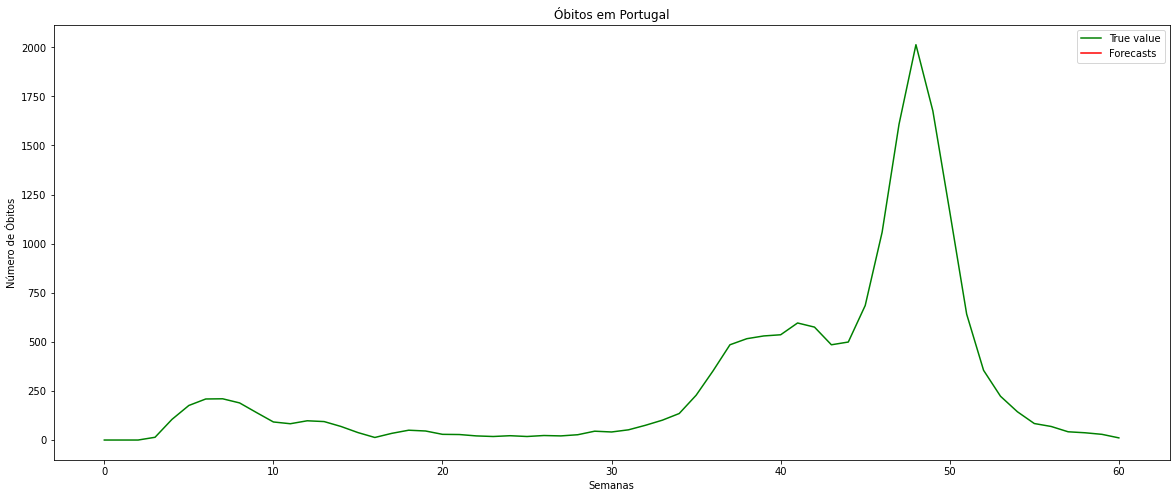

Epoch 1/90
7/7 [==============================] - 3s 128ms/step - loss: 0.8927 - mae: 0.8916 - rmse: 0.8927 - val_loss: 0.9633 - val_mae: 0.9621 - val_rmse: 0.9633
Epoch 2/90
7/7 [==============================] - 0s 9ms/step - loss: 0.8866 - mae: 0.8854 - rmse: 0.8866 - val_loss: 0.9565 - val_mae: 0.9552 - val_rmse: 0.9565
Epoch 3/90
7/7 [==============================] - 0s 8ms/step - loss: 0.8802 - mae: 0.8790 - rmse: 0.8802 - val_loss: 0.9493 - val_mae: 0.9478 - val_rmse: 0.9493
Epoch 4/90
7/7 [==============================] - 0s 9ms/step - loss: 0.8734 - mae: 0.8719 - rmse: 0.8734 - val_loss: 0.9413 - val_mae: 0.9394 - val_rmse: 0.9413
Epoch 5/90
7/7 [==============================] - 0s 9ms/step - loss: 0.8656 - mae: 0.8639 - rmse: 0.8656 - val_loss: 0.9322 - val_mae: 0.9299 - val_rmse: 0.9322
Epoch 6/90
7/7 [==============================] - 0s 9ms/step - loss: 0.8568 - mae: 0.8546 - rmse: 0.8568 - val_loss: 0.9216 - val_mae: 0.9187 - val_rmse: 0.9216
Epoch 7/90
7/7 [==========

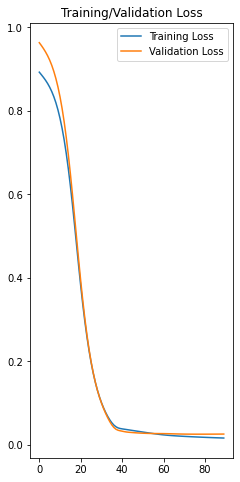

Epoch 1/90
14/14 [==============================] - 3s 64ms/step - loss: 0.0270 - mae: 0.0256 - rmse: 0.0271 - val_loss: 0.0328 - val_mae: 0.0315 - val_rmse: 0.0328
Epoch 2/90
14/14 [==============================] - 0s 8ms/step - loss: 0.0327 - mae: 0.0313 - rmse: 0.0324 - val_loss: 0.0305 - val_mae: 0.0294 - val_rmse: 0.0305
Epoch 3/90
14/14 [==============================] - 0s 7ms/step - loss: 0.0283 - mae: 0.0264 - rmse: 0.0284 - val_loss: 0.0390 - val_mae: 0.0381 - val_rmse: 0.0390
Epoch 4/90
14/14 [==============================] - 0s 7ms/step - loss: 0.0214 - mae: 0.0197 - rmse: 0.0212 - val_loss: 0.0218 - val_mae: 0.0206 - val_rmse: 0.0218
Epoch 5/90
14/14 [==============================] - 0s 10ms/step - loss: 0.0238 - mae: 0.0224 - rmse: 0.0237 - val_loss: 0.0259 - val_mae: 0.0247 - val_rmse: 0.0259
Epoch 6/90
14/14 [==============================] - 0s 8ms/step - loss: 0.0207 - mae: 0.0192 - rmse: 0.0204 - val_loss: 0.0187 - val_mae: 0.0171 - val_rmse: 0.0187
Epoch 7/90
14/

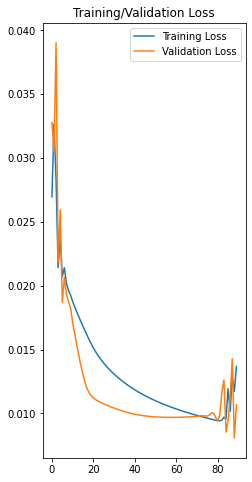

Epoch 1/90
20/20 [==============================] - 0s 9ms/step - loss: 0.0504 - mae: 0.0482 - rmse: 0.0601 - val_loss: 0.4287 - val_mae: 0.4198 - val_rmse: 0.4287
Epoch 2/90
20/20 [==============================] - 0s 8ms/step - loss: 0.0429 - mae: 0.0406 - rmse: 0.0516 - val_loss: 0.4009 - val_mae: 0.3913 - val_rmse: 0.4009
Epoch 3/90
20/20 [==============================] - 0s 9ms/step - loss: 0.0389 - mae: 0.0364 - rmse: 0.0463 - val_loss: 0.3749 - val_mae: 0.3646 - val_rmse: 0.3749
Epoch 4/90
20/20 [==============================] - 0s 8ms/step - loss: 0.0348 - mae: 0.0325 - rmse: 0.0411 - val_loss: 0.3505 - val_mae: 0.3393 - val_rmse: 0.3505
Epoch 5/90
20/20 [==============================] - 0s 8ms/step - loss: 0.0314 - mae: 0.0294 - rmse: 0.0368 - val_loss: 0.3259 - val_mae: 0.3137 - val_rmse: 0.3259
Epoch 6/90
20/20 [==============================] - 0s 8ms/step - loss: 0.0284 - mae: 0.0266 - rmse: 0.0329 - val_loss: 0.3029 - val_mae: 0.2899 - val_rmse: 0.3029
Epoch 7/90
20/20

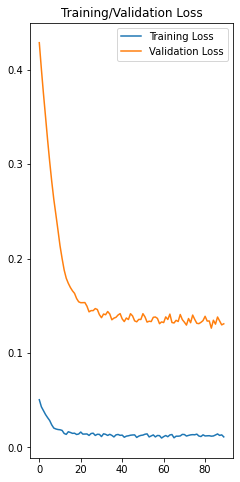

[array([[446.3493 , 441.79904, 429.32538, 412.51276, 456.9172 , 416.73843,
        418.58997, 479.6788 , 441.96222, 429.31366, 470.39743, 412.22516,
        423.43353, 376.62784, 422.83292, 406.6869 , 449.09708, 432.5245 ,
        399.65137, 390.06613, 463.62247, 421.72684, 457.9972 , 437.24625,
        462.20755, 440.71036, 403.52097, 396.28983, 437.14276, 455.85873,
        384.16238, 435.65176, 417.3794 , 439.4294 , 419.41083, 455.64624,
        437.08258, 414.56714, 453.6482 , 414.96573, 454.4611 , 428.23495,
        378.41284, 435.6669 , 384.0763 , 431.4234 , 415.2913 , 421.75443,
        454.6408 , 428.16855, 422.32837, 439.1484 , 450.0093 , 456.1356 ,
        426.75308, 459.75046, 432.51196, 429.8666 , 432.64066, 440.20374,
        402.659  , 467.79083, 474.18665, 430.9118 , 453.48416, 405.02252,
        431.756  , 471.2707 , 412.7404 , 403.2371 , 452.36   , 448.29245,
        387.53394, 424.03336, 378.29016, 442.37   , 391.92343, 437.0962 ,
        442.897  , 494.61475, 435.849

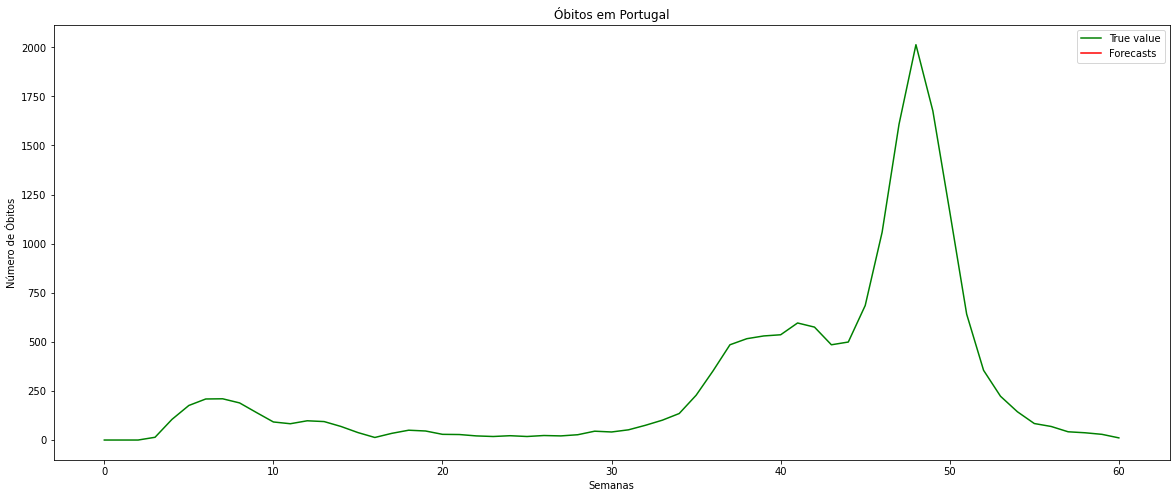

Epoch 1/120
5/5 [==============================] - 4s 192ms/step - loss: 0.8896 - mae: 0.8875 - rmse: 0.8931 - val_loss: 0.9634 - val_mae: 0.9623 - val_rmse: 0.9634
Epoch 2/120
5/5 [==============================] - 0s 12ms/step - loss: 0.8890 - mae: 0.8869 - rmse: 0.8926 - val_loss: 0.9629 - val_mae: 0.9617 - val_rmse: 0.9629
Epoch 3/120
5/5 [==============================] - 0s 12ms/step - loss: 0.8884 - mae: 0.8864 - rmse: 0.8920 - val_loss: 0.9623 - val_mae: 0.9611 - val_rmse: 0.9623
Epoch 4/120
5/5 [==============================] - 0s 13ms/step - loss: 0.8879 - mae: 0.8858 - rmse: 0.8915 - val_loss: 0.9617 - val_mae: 0.9606 - val_rmse: 0.9617
Epoch 5/120
5/5 [==============================] - 0s 15ms/step - loss: 0.8873 - mae: 0.8853 - rmse: 0.8909 - val_loss: 0.9611 - val_mae: 0.9600 - val_rmse: 0.9611
Epoch 6/120
5/5 [==============================] - 0s 13ms/step - loss: 0.8868 - mae: 0.8847 - rmse: 0.8904 - val_loss: 0.9605 - val_mae: 0.9594 - val_rmse: 0.9605
Epoch 7/120
5/5

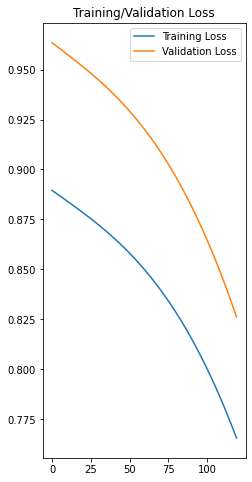

Epoch 1/120
9/9 [==============================] - 2s 11ms/step - loss: 0.7972 - mae: 0.7861 - rmse: 0.7972 - val_loss: 0.8235 - val_mae: 0.8149 - val_rmse: 0.8235
Epoch 2/120
9/9 [==============================] - 0s 10ms/step - loss: 0.7931 - mae: 0.7816 - rmse: 0.7931 - val_loss: 0.8194 - val_mae: 0.8103 - val_rmse: 0.8194
Epoch 3/120
9/9 [==============================] - 0s 8ms/step - loss: 0.7889 - mae: 0.7770 - rmse: 0.7889 - val_loss: 0.8150 - val_mae: 0.8055 - val_rmse: 0.8150
Epoch 4/120
9/9 [==============================] - 0s 8ms/step - loss: 0.7845 - mae: 0.7722 - rmse: 0.7845 - val_loss: 0.8106 - val_mae: 0.8007 - val_rmse: 0.8106
Epoch 5/120
9/9 [==============================] - 0s 11ms/step - loss: 0.7801 - mae: 0.7673 - rmse: 0.7801 - val_loss: 0.8061 - val_mae: 0.7957 - val_rmse: 0.8061
Epoch 6/120
9/9 [==============================] - 0s 11ms/step - loss: 0.7757 - mae: 0.7623 - rmse: 0.7757 - val_loss: 0.8015 - val_mae: 0.7907 - val_rmse: 0.8015
Epoch 7/120
9/9 [=

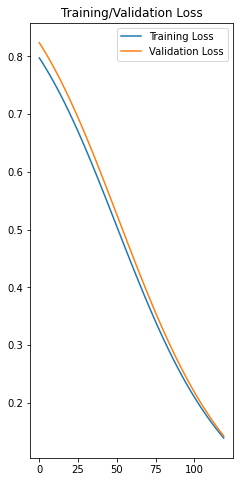

Epoch 1/120
13/13 [==============================] - 0s 10ms/step - loss: 0.1535 - mae: 0.1094 - rmse: 0.1535 - val_loss: 0.4555 - val_mae: 0.4525 - val_rmse: 0.4129
Epoch 2/120
13/13 [==============================] - 0s 9ms/step - loss: 0.1492 - mae: 0.1062 - rmse: 0.1492 - val_loss: 0.4544 - val_mae: 0.4514 - val_rmse: 0.4119
Epoch 3/120
13/13 [==============================] - 0s 8ms/step - loss: 0.1451 - mae: 0.1032 - rmse: 0.1451 - val_loss: 0.4533 - val_mae: 0.4503 - val_rmse: 0.4107
Epoch 4/120
13/13 [==============================] - 0s 8ms/step - loss: 0.1411 - mae: 0.1004 - rmse: 0.1411 - val_loss: 0.4521 - val_mae: 0.4491 - val_rmse: 0.4096
Epoch 5/120
13/13 [==============================] - 0s 8ms/step - loss: 0.1373 - mae: 0.0977 - rmse: 0.1373 - val_loss: 0.4510 - val_mae: 0.4479 - val_rmse: 0.4085
Epoch 6/120
13/13 [==============================] - 0s 9ms/step - loss: 0.1336 - mae: 0.0951 - rmse: 0.1336 - val_loss: 0.4499 - val_mae: 0.4468 - val_rmse: 0.4074
Epoch 7/1

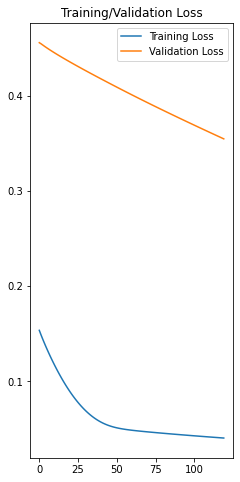

[array([[523.31903, 551.26276, 488.45255, 523.29504, 552.6382 , 529.1374 ,
        510.55405, 566.4464 , 547.7537 , 460.6636 , 506.65216, 499.2986 ,
        464.27292, 483.17258, 487.85593, 509.97223, 522.262  , 543.11224,
        500.5111 , 566.94165, 539.78436, 445.49323, 535.79486, 509.1795 ,
        488.54852, 503.32043, 473.24658, 503.53262, 475.0932 , 509.2174 ,
        552.09503, 512.3684 , 524.9556 , 571.6136 , 562.8514 , 514.1195 ,
        515.62384, 415.4062 , 502.2113 , 542.08466, 538.32715, 556.2122 ,
        467.07425, 463.90942, 407.4682 , 533.64655, 555.90735, 565.58887,
        593.14417, 522.8229 , 503.3088 , 516.2106 , 553.44617, 577.00397,
        455.83273, 503.32986, 543.793  , 529.9442 , 545.05646, 541.8289 ,
        486.37903, 518.91296, 557.7532 , 489.5099 , 513.36835, 478.57605,
        548.9848 , 552.72473, 548.3434 , 534.1861 , 595.802  , 519.90454,
        537.4396 , 494.6452 , 575.0772 , 544.3525 , 569.1381 , 514.5957 ,
        507.3424 , 528.48987, 462.901

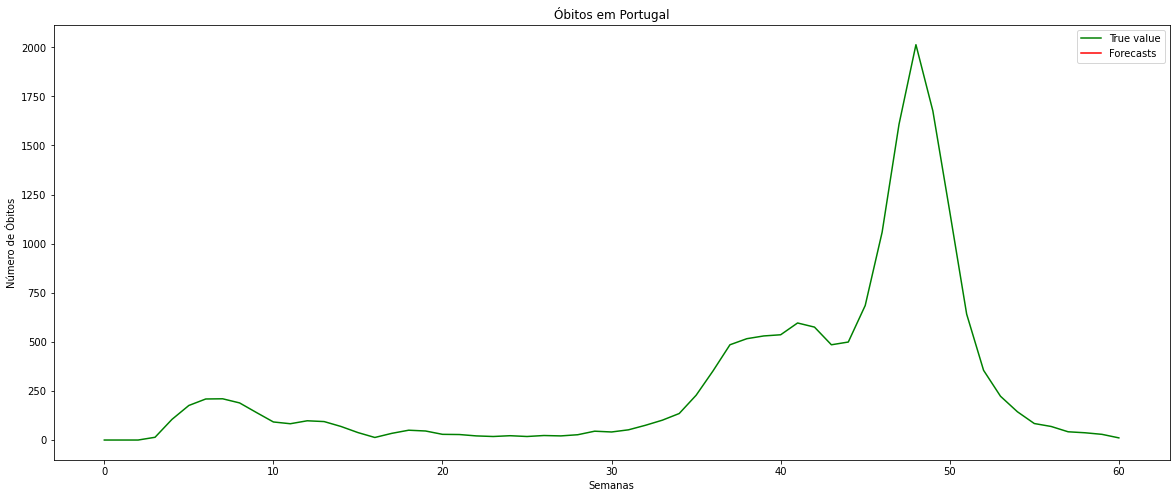

Epoch 1/50
12/12 [==============================] - 4s 74ms/step - loss: 0.7845 - mae: 0.7730 - rmse: 0.7845 - val_loss: 0.6996 - val_mae: 0.6557 - val_rmse: 0.6996
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4389 - mae: 0.3545 - rmse: 0.4389 - val_loss: 0.3132 - val_mae: 0.2223 - val_rmse: 0.3132
Epoch 3/50
12/12 [==============================] - 0s 9ms/step - loss: 0.2055 - mae: 0.1579 - rmse: 0.2055 - val_loss: 0.1189 - val_mae: 0.0867 - val_rmse: 0.1189
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0953 - mae: 0.0833 - rmse: 0.0953 - val_loss: 0.0610 - val_mae: 0.0519 - val_rmse: 0.0610
Epoch 5/50
12/12 [==============================] - 0s 8ms/step - loss: 0.0834 - mae: 0.0775 - rmse: 0.0834 - val_loss: 0.0632 - val_mae: 0.0593 - val_rmse: 0.0632
Epoch 6/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0721 - mae: 0.0663 - rmse: 0.0721 - val_loss: 0.0704 - val_mae: 0.0636 - val_rmse: 0.0704
Epoch 7/50
12/1

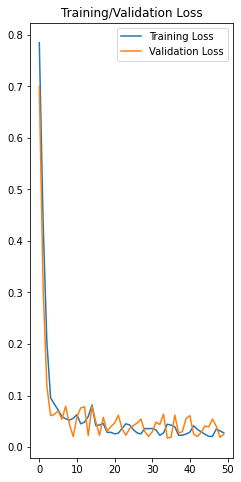

Epoch 1/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0214 - mae: 0.0197 - rmse: 0.0214 - val_loss: 0.0191 - val_mae: 0.0179 - val_rmse: 0.0191
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0300 - mae: 0.0284 - rmse: 0.0300 - val_loss: 0.0236 - val_mae: 0.0226 - val_rmse: 0.0236
Epoch 3/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0319 - mae: 0.0296 - rmse: 0.0319 - val_loss: 0.0200 - val_mae: 0.0178 - val_rmse: 0.0200
Epoch 4/50
25/25 [==============================] - 0s 8ms/step - loss: 0.0247 - mae: 0.0225 - rmse: 0.0247 - val_loss: 0.0149 - val_mae: 0.0139 - val_rmse: 0.0149
Epoch 5/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0218 - mae: 0.0195 - rmse: 0.0218 - val_loss: 0.0214 - val_mae: 0.0191 - val_rmse: 0.0214
Epoch 6/50
25/25 [==============================] - 0s 7ms/step - loss: 0.0536 - mae: 0.0497 - rmse: 0.0536 - val_loss: 0.0780 - val_mae: 0.0732 - val_rmse: 0.0780
Epoch 7/50
25/25

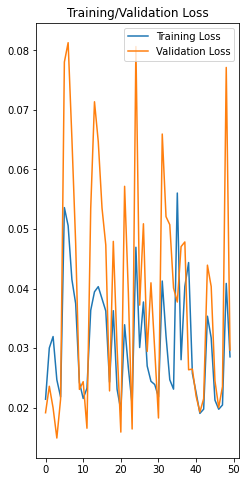

Epoch 1/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0771 - mae: 0.0748 - rmse: 0.0771 - val_loss: 0.5422 - val_mae: 0.5401 - val_rmse: 0.5422
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0943 - mae: 0.0914 - rmse: 0.0943 - val_loss: 0.1596 - val_mae: 0.1548 - val_rmse: 0.1596
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0757 - mae: 0.0724 - rmse: 0.0757 - val_loss: 0.0755 - val_mae: 0.0696 - val_rmse: 0.0755
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0633 - mae: 0.0592 - rmse: 0.0633 - val_loss: 0.0709 - val_mae: 0.0669 - val_rmse: 0.0709
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.0589 - mae: 0.0526 - rmse: 0.0589 - val_loss: 0.0708 - val_mae: 0.0660 - val_rmse: 0.0708
Epoch 6/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0405 - mae: 0.0377 - rmse: 0.0405 - val_loss: 0.1332 - val_mae: 0.1302 - val_rmse: 0.1332
Epoch 7/50
37/37

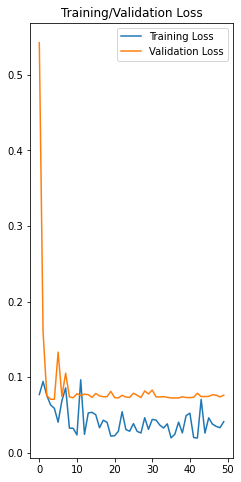

[array([[203.72913 , 202.60403 , 172.14594 , 155.10927 , 179.46371 ,
        175.58888 , 157.47752 , 151.05296 , 157.3684  , 183.95496 ,
        152.24716 , 121.89328 , 217.69888 , 211.80052 , 164.66415 ,
        140.09169 , 181.49318 , 148.1947  ,  86.81609 , 211.70837 ,
        227.13611 , 192.95792 , 188.69583 , 215.93944 , 149.78197 ,
        183.84764 , 202.04742 , 215.07999 ,  66.70813 , 162.00343 ,
        197.81871 , 162.40184 , 152.62842 , 203.33012 , 215.1704  ,
        270.3337  , 215.7318  , 178.38127 , 153.93222 , 211.09256 ,
        194.9479  , 222.13248 , 177.65897 , 175.2876  , 183.8738  ,
        213.89389 , 205.39835 , 226.20354 , 160.69507 , 212.09467 ,
        160.90721 , 199.9087  , 190.93156 , 135.84941 , 209.16087 ,
        260.39374 , 217.02913 , 160.19426 , 176.05922 , 179.08739 ,
        191.04129 , 192.6589  , 229.04813 , 174.19958 , 164.388   ,
        203.77022 , 142.65263 , 192.81015 , 174.05849 , 107.052315,
        125.3739  , 198.86346 , 185.53233 , 132

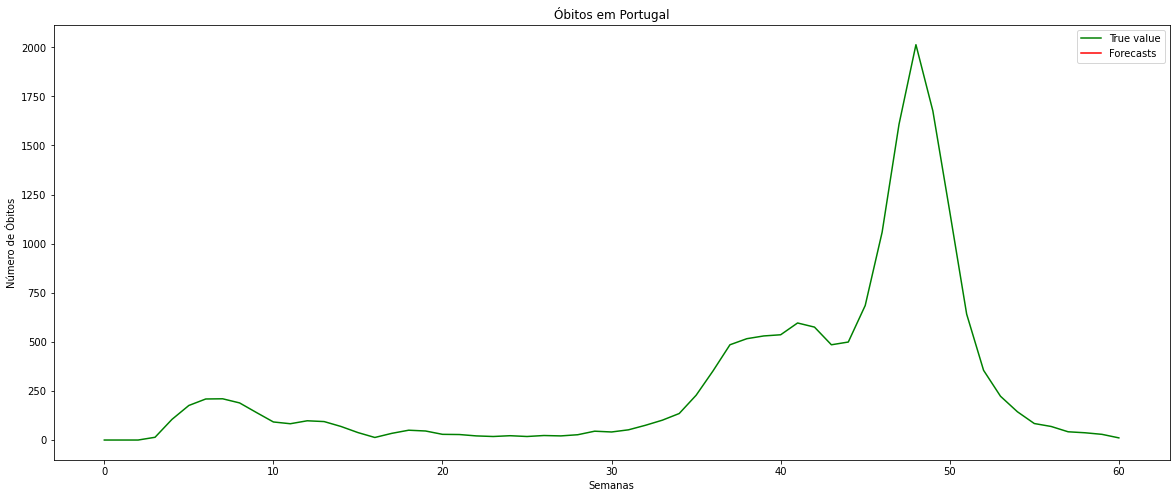

Epoch 1/90
6/6 [==============================] - 3s 164ms/step - loss: 0.8679 - mae: 0.8647 - rmse: 0.8679 - val_loss: 0.9531 - val_mae: 0.9504 - val_rmse: 0.9531
Epoch 2/90
6/6 [==============================] - 0s 10ms/step - loss: 0.8578 - mae: 0.8539 - rmse: 0.8578 - val_loss: 0.9428 - val_mae: 0.9393 - val_rmse: 0.9428
Epoch 3/90
6/6 [==============================] - 0s 11ms/step - loss: 0.8476 - mae: 0.8427 - rmse: 0.8476 - val_loss: 0.9322 - val_mae: 0.9276 - val_rmse: 0.9322
Epoch 4/90
6/6 [==============================] - 0s 11ms/step - loss: 0.8370 - mae: 0.8308 - rmse: 0.8370 - val_loss: 0.9210 - val_mae: 0.9148 - val_rmse: 0.9210
Epoch 5/90
6/6 [==============================] - 0s 12ms/step - loss: 0.8258 - mae: 0.8177 - rmse: 0.8258 - val_loss: 0.9089 - val_mae: 0.9007 - val_rmse: 0.9089
Epoch 6/90
6/6 [==============================] - 0s 11ms/step - loss: 0.8137 - mae: 0.8032 - rmse: 0.8137 - val_loss: 0.8957 - val_mae: 0.8849 - val_rmse: 0.8957
Epoch 7/90
6/6 [=====

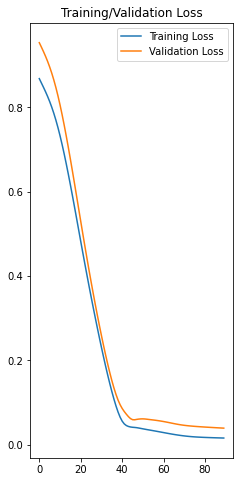

Epoch 1/90
13/13 [==============================] - 3s 71ms/step - loss: 0.0335 - mae: 0.0318 - rmse: 0.0336 - val_loss: 0.0207 - val_mae: 0.0177 - val_rmse: 0.0207
Epoch 2/90
13/13 [==============================] - 0s 11ms/step - loss: 0.0357 - mae: 0.0339 - rmse: 0.0352 - val_loss: 0.0093 - val_mae: 0.0078 - val_rmse: 0.0093
Epoch 3/90
13/13 [==============================] - 0s 10ms/step - loss: 0.0337 - mae: 0.0316 - rmse: 0.0334 - val_loss: 0.0122 - val_mae: 0.0105 - val_rmse: 0.0122
Epoch 4/90
13/13 [==============================] - 0s 12ms/step - loss: 0.0266 - mae: 0.0242 - rmse: 0.0264 - val_loss: 0.0084 - val_mae: 0.0068 - val_rmse: 0.0084
Epoch 5/90
13/13 [==============================] - 0s 12ms/step - loss: 0.0231 - mae: 0.0205 - rmse: 0.0225 - val_loss: 0.0086 - val_mae: 0.0071 - val_rmse: 0.0086
Epoch 6/90
13/13 [==============================] - 0s 12ms/step - loss: 0.0233 - mae: 0.0213 - rmse: 0.0228 - val_loss: 0.0082 - val_mae: 0.0066 - val_rmse: 0.0082
Epoch 7/90

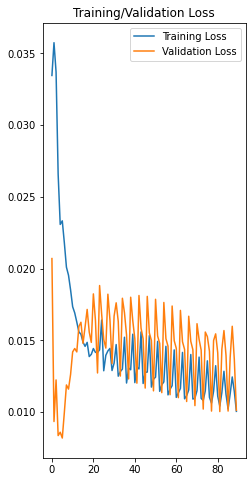

Epoch 1/90
19/19 [==============================] - 0s 13ms/step - loss: 0.0423 - mae: 0.0392 - rmse: 0.0491 - val_loss: 0.4851 - val_mae: 0.4741 - val_rmse: 0.4851
Epoch 2/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0507 - mae: 0.0475 - rmse: 0.0545 - val_loss: 0.4468 - val_mae: 0.4346 - val_rmse: 0.4468
Epoch 3/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0425 - mae: 0.0397 - rmse: 0.0455 - val_loss: 0.4128 - val_mae: 0.3995 - val_rmse: 0.4128
Epoch 4/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0352 - mae: 0.0321 - rmse: 0.0375 - val_loss: 0.3844 - val_mae: 0.3701 - val_rmse: 0.3844
Epoch 5/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0307 - mae: 0.0277 - rmse: 0.0326 - val_loss: 0.3607 - val_mae: 0.3455 - val_rmse: 0.3607
Epoch 6/90
19/19 [==============================] - 0s 11ms/step - loss: 0.0276 - mae: 0.0244 - rmse: 0.0293 - val_loss: 0.3400 - val_mae: 0.3239 - val_rmse: 0.3400
Epoch 7/90

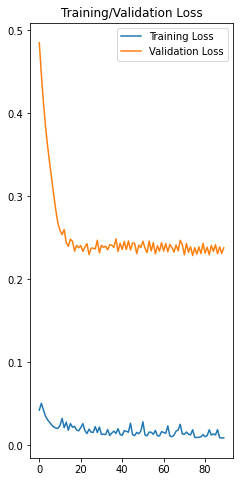

[array([[581.6899 , 536.8432 , 600.29596, 624.80426, 566.91034, 528.7055 ,
        610.80865, 601.73254, 576.36957, 591.921  , 643.36676, 626.13525,
        609.8713 , 695.1427 , 696.724  , 699.56665, 621.85266, 528.43634,
        637.4569 , 660.8905 , 646.14465, 802.00085, 741.3719 , 618.6108 ,
        681.2407 , 656.7131 , 654.261  , 666.83344, 596.92755, 628.65936,
        730.8663 , 710.8277 , 596.14185, 666.69745, 683.6602 , 697.7269 ,
        424.03143, 796.2183 , 831.20087, 660.3748 , 628.6128 , 692.6386 ,
        634.4789 , 709.5475 , 582.3067 , 641.61707, 671.0789 , 652.57306,
        716.6835 , 682.7902 , 721.4827 , 545.8007 , 697.73505, 638.6923 ,
        586.4984 , 666.9657 , 608.70935, 644.37213, 635.77924, 645.52277,
        643.7098 , 760.8123 , 589.7984 , 702.45056, 696.48553, 648.7993 ,
        636.54364, 647.86035, 640.21265, 544.7034 , 635.66895, 716.6577 ,
        505.88498, 659.65454, 662.9468 , 617.15515, 719.5807 , 673.1848 ,
        584.776  , 739.5895 , 585.750

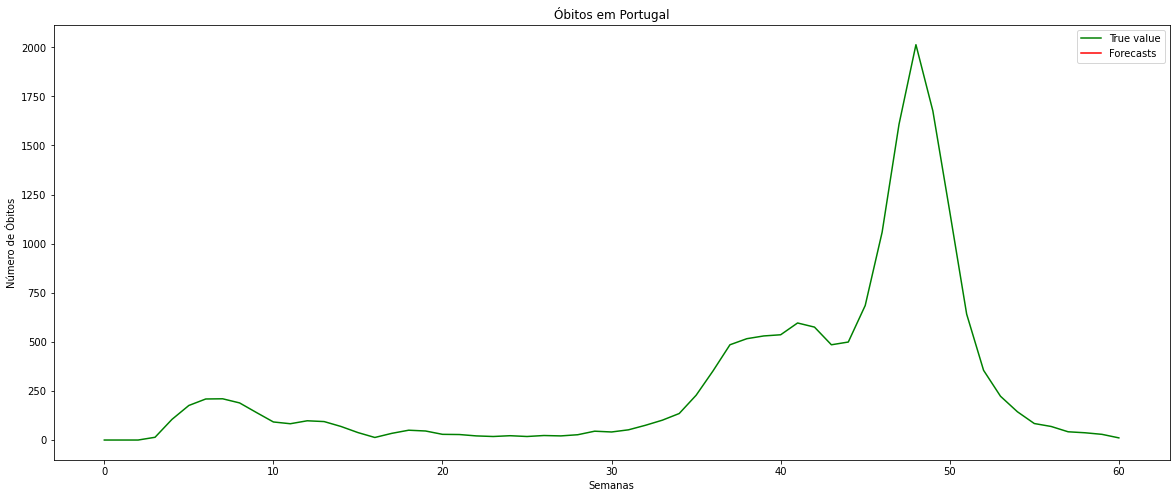

Epoch 1/120
4/4 [==============================] - 4s 260ms/step - loss: 0.8808 - mae: 0.8762 - rmse: 0.8808 - val_loss: 0.9717 - val_mae: 0.9685 - val_rmse: 0.9717
Epoch 2/120
4/4 [==============================] - 0s 16ms/step - loss: 0.8802 - mae: 0.8756 - rmse: 0.8802 - val_loss: 0.9710 - val_mae: 0.9678 - val_rmse: 0.9710
Epoch 3/120
4/4 [==============================] - 0s 16ms/step - loss: 0.8795 - mae: 0.8749 - rmse: 0.8795 - val_loss: 0.9704 - val_mae: 0.9672 - val_rmse: 0.9704
Epoch 4/120
4/4 [==============================] - 0s 16ms/step - loss: 0.8789 - mae: 0.8743 - rmse: 0.8789 - val_loss: 0.9697 - val_mae: 0.9665 - val_rmse: 0.9697
Epoch 5/120
4/4 [==============================] - 0s 17ms/step - loss: 0.8783 - mae: 0.8737 - rmse: 0.8783 - val_loss: 0.9691 - val_mae: 0.9659 - val_rmse: 0.9691
Epoch 6/120
4/4 [==============================] - 0s 24ms/step - loss: 0.8777 - mae: 0.8730 - rmse: 0.8777 - val_loss: 0.9684 - val_mae: 0.9653 - val_rmse: 0.9684
Epoch 7/120
4/4

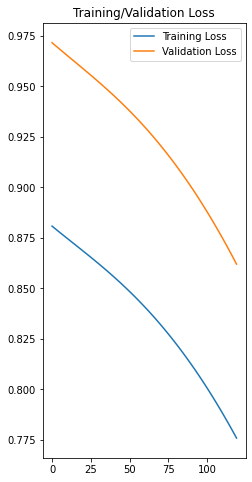

Epoch 1/120
9/9 [==============================] - 2s 14ms/step - loss: 0.8250 - mae: 0.8060 - rmse: 0.8287 - val_loss: 0.8593 - val_mae: 0.8437 - val_rmse: 0.8593
Epoch 2/120
9/9 [==============================] - 0s 12ms/step - loss: 0.8215 - mae: 0.8018 - rmse: 0.8253 - val_loss: 0.8557 - val_mae: 0.8394 - val_rmse: 0.8557
Epoch 3/120
9/9 [==============================] - 0s 14ms/step - loss: 0.8179 - mae: 0.7975 - rmse: 0.8217 - val_loss: 0.8519 - val_mae: 0.8349 - val_rmse: 0.8519
Epoch 4/120
9/9 [==============================] - 0s 13ms/step - loss: 0.8143 - mae: 0.7930 - rmse: 0.8180 - val_loss: 0.8480 - val_mae: 0.8303 - val_rmse: 0.8480
Epoch 5/120
9/9 [==============================] - 0s 14ms/step - loss: 0.8106 - mae: 0.7884 - rmse: 0.8143 - val_loss: 0.8441 - val_mae: 0.8256 - val_rmse: 0.8441
Epoch 6/120
9/9 [==============================] - 0s 12ms/step - loss: 0.8069 - mae: 0.7838 - rmse: 0.8106 - val_loss: 0.8402 - val_mae: 0.8209 - val_rmse: 0.8402
Epoch 7/120
9/9 

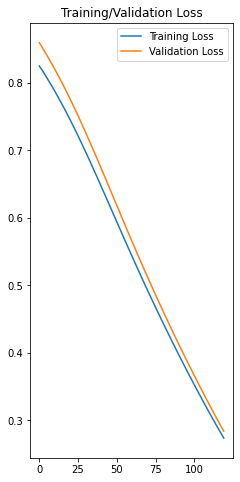

Epoch 1/120
13/13 [==============================] - 0s 14ms/step - loss: 0.2598 - mae: 0.1901 - rmse: 0.2608 - val_loss: 0.4665 - val_mae: 0.4606 - val_rmse: 0.4347
Epoch 2/120
13/13 [==============================] - 0s 10ms/step - loss: 0.2548 - mae: 0.1857 - rmse: 0.2556 - val_loss: 0.4635 - val_mae: 0.4575 - val_rmse: 0.4321
Epoch 3/120
13/13 [==============================] - 0s 13ms/step - loss: 0.2501 - mae: 0.1817 - rmse: 0.2507 - val_loss: 0.4603 - val_mae: 0.4542 - val_rmse: 0.4293
Epoch 4/120
13/13 [==============================] - 0s 13ms/step - loss: 0.2455 - mae: 0.1778 - rmse: 0.2459 - val_loss: 0.4573 - val_mae: 0.4510 - val_rmse: 0.4267
Epoch 5/120
13/13 [==============================] - 0s 11ms/step - loss: 0.2411 - mae: 0.1741 - rmse: 0.2413 - val_loss: 0.4544 - val_mae: 0.4480 - val_rmse: 0.4242
Epoch 6/120
13/13 [==============================] - 0s 14ms/step - loss: 0.2367 - mae: 0.1705 - rmse: 0.2368 - val_loss: 0.4518 - val_mae: 0.4452 - val_rmse: 0.4219
Epoc

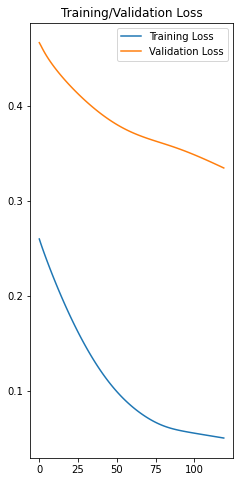

[array([[815.7536 , 732.0138 , 710.1677 , 799.07263, 701.0009 , 510.6325 ,
        795.82355, 765.0115 , 686.91   , 707.5528 , 679.6578 , 708.06055,
        810.88275, 781.7823 , 628.4763 , 642.96063, 772.03766, 879.40906,
        718.26215, 732.5892 , 700.5096 , 687.1076 , 773.26355, 627.9766 ,
        699.5051 , 537.6604 , 746.5908 , 796.0872 , 700.85834, 685.26056,
        741.0038 , 778.9173 , 511.62692, 724.1809 , 677.5726 , 653.67865,
        750.7795 , 894.96594, 807.84296, 742.05206, 763.71   , 745.8402 ,
        616.149  , 853.3381 , 753.82544, 835.2206 , 892.038  , 689.52515,
        703.9866 , 686.42065, 842.08514, 724.98584, 823.92505, 594.4841 ,
        762.93024, 749.8019 , 726.6954 , 592.29926, 651.76166, 759.5431 ,
        831.1252 , 639.40466, 709.0845 , 753.81757, 683.00415, 767.87695,
        690.6506 , 740.5423 , 723.27124, 803.8484 , 656.181  , 743.67413,
        676.92084, 770.6064 , 802.574  , 642.33636, 764.2152 , 805.94147,
        695.4816 , 752.6134 , 743.076

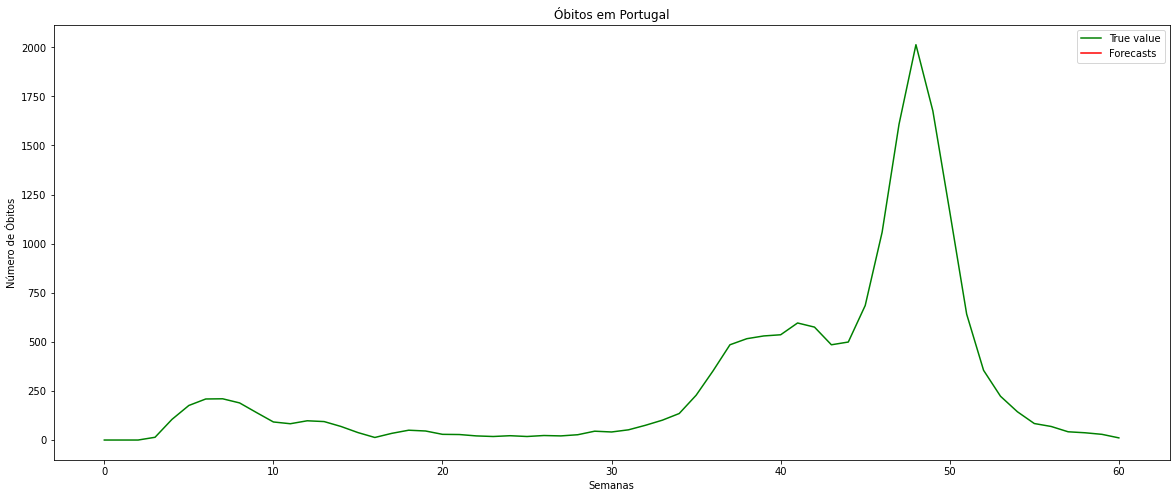

In [19]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  learning_rate = tunning_dict[t]['learning_rate']

  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print('Previsões:')
  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [20]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [21]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.056273062142233064, 0.053582442601521806, 0.056273062142233064, 0.06002580127368371, 0.05727669424066941, 0.06002580127368371] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.14395331331218283, 0.13440793323641023, 0.14410709217811626, 0.22456264260845882, 0.2127799285110086, 0.22500488993711767] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.6118410382047296, 0.5937930184106032, 0.6141662855694691, 0.7008489886919658, 0.6944958508014679, 0.6885455240805944] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.04570312918060355, 0.04243212671329578, 0.04570312918060355, 0.05596853841561824, 0.05330881473556575, 0.05596853841561824] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.07935945902157712, 0.07357141302760553, 0.07948700961208453, 0.1320470978954324, 0.11826174485117748, 0.1

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.056273,0.053582,0.056273,0.060026,0.057277,0.060026
2,0.143953,0.134408,0.144107,0.224563,0.212780,0.225005
3,0.611841,0.593793,0.614166,0.700849,0.694496,0.688546
4,0.045703,0.042432,0.045703,0.055969,0.053309,0.055969
5,0.079359,0.073571,0.079487,0.132047,0.118262,0.132047
6,0.452286,0.431443,0.453417,0.594321,0.576504,0.581111
7,0.046808,0.042473,0.046808,0.063597,0.060098,0.063597
8,0.088008,0.077305,0.087965,0.178477,0.162436,0.178477
9,0.497985,0.463350,0.498655,0.626104,0.597077,0.619050


In [22]:
df.columns

Index(['obitos', 'confirmados_novos', 'recuperados', 'Temperature',
       'Visibility', 'total_testes', 'testes_pcr', 'testes_antigenio',
       'new_cases_per_million_Austria', 'new_deaths_per_million_Austria',
       'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium',
       'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium',
       'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada',
       'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada',
       'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia',
       'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark',
       'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France',
       'new_cases_per_million_Georgia', 'new_cases_per_million_Germany',
       'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany',
       'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary',
       'positive_rate_India', 